## Задание  
Обучить сиамскую сеть для верификации лиц на датасете LFW  
Библиотеки: [Python, Tensorflow]

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow_datasets as tfds

## Загрузка и подготовка датасета LFW

In [2]:
train_ds, ds_info = tfds.load(
    'lfw',
    as_supervised=True,
    with_info=True,
    split='train',
)

In [3]:
ds_info

tfds.core.DatasetInfo(
    name='lfw',
    full_name='lfw/0.1.0',
    description="""
    Labeled Faces in the Wild:
            A Database for Studying Face Recognition in
            Unconstrained Environments
    """,
    homepage='http://vis-www.cs.umass.edu/lfw',
    data_path='~\\tensorflow_datasets\\lfw\\0.1.0',
    file_format=tfrecord,
    download_size=172.20 MiB,
    dataset_size=180.28 MiB,
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    supervised_keys=('label', 'image'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=13233, num_shards=2>,
    },
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts,

## Создание модели CNN

In [4]:
EMB_SIZE = 64

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

## Contrastive Loss

In [5]:
MARGIN = 30.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

## Подготовка пайплайна данных

In [6]:
len(train_ds)

13233

In [7]:
def preprocess(label, image):
    return label, tf.cast(image, tf.float32) / 255.

In [8]:
BATCH_SIZE = 64
NUM_EPOCHS = 10

train_ds = train_ds.map(preprocess)
train_ds = train_ds.shuffle(buffer_size=len(train_ds), seed=42)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

## Визуализация датасета LFW

In [9]:
some_samples = next(iter(train_ds))
images = some_samples[1].numpy()[:4]
labels = some_samples[0].numpy()[:4]

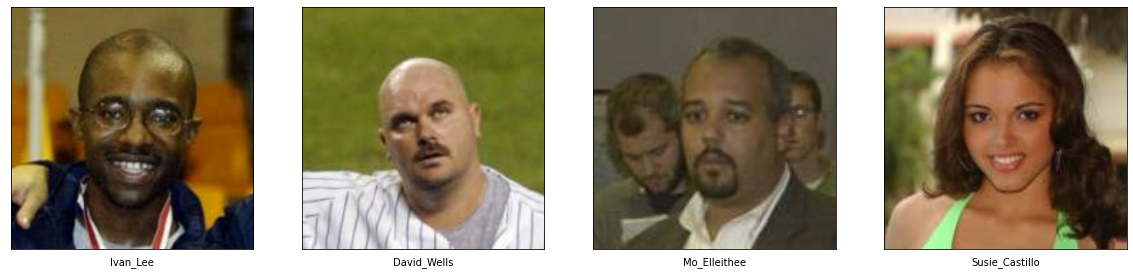

In [10]:
plt.figure(figsize=(20,10))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(images[i].reshape(250,250,3))
    plt.xlabel(labels[i].decode())
plt.show()

## Подготовка к обучению

In [11]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

## Обучение модели

In [12]:
%%time

for iteration, (labels, images) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 200 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 886.616943359375
[200] Loss: 0.0
[400] Loss: 2.256699562072754
[600] Loss: 0.09007542580366135
[800] Loss: 0.0
[1000] Loss: 2.5990753173828125
[1200] Loss: 8.350895881652832
[1400] Loss: 0.0
[1600] Loss: 0.0
[1800] Loss: 1.5410137176513672
[2000] Loss: 0.0
CPU times: total: 1d 7h 19min 34s
Wall time: 9h 55min 33s


## Тестирование на данных

In [86]:
def load_and_prepare_image(fpath):
    import imageio
    from skimage.transform import resize
    img = imageio.v2.imread(fpath, pilmode="RGB")
    img = img.astype(np.float32)/255
    img = resize(img, (250, 250, 3), mode='reflect', anti_aliasing=True)
    img = np.reshape(img, (250, 250, 3))
    return img

img_a1 = load_and_prepare_image('Vladimir_Putin_0001.jpg')
img_a2 = load_and_prepare_image('Vladimir_Putin_0002.jpg')
img_a3 = load_and_prepare_image('Vladimir_Putin_0003.jpg')
img_b1 = load_and_prepare_image('Robbie_Williams_0001.jpg')
img_b2 = load_and_prepare_image('Robbie_Williams_0002.jpg')
img_b3 = load_and_prepare_image('Robbie_Williams_0003.jpg')

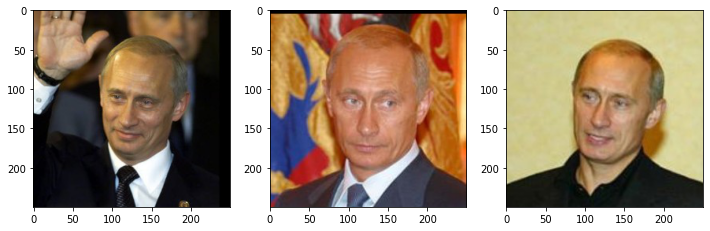

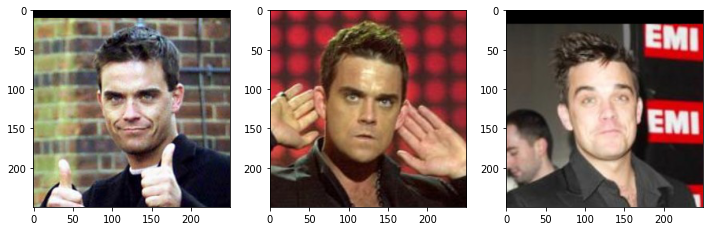

In [87]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(img_a1)
ax = fig.add_subplot(1, 3, 2)
ax.imshow(img_a2)
ax = fig.add_subplot(1, 3, 3)
ax.imshow(img_a3)
fig = plt.figure(figsize=(12,4))

ax = fig.add_subplot(1, 3, 1)
ax.imshow(img_b1)
ax = fig.add_subplot(1, 3, 2)
ax.imshow(img_b2)
ax = fig.add_subplot(1, 3, 3)
ax.imshow(img_b3)
plt.show()

In [88]:
embs = model(np.stack((img_a1, img_a2, img_a3, img_b1, img_b2, img_b3), axis=0))

## Вычисление расстояний между эмбеддингами

In [89]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb_a1 = embs[0,:]
emb_a2 = embs[1,:]
emb_a3 = embs[2,:]

emb_b1 = embs[3,:]
emb_b2 = embs[4,:]
emb_b3 = embs[5,:]

print('Vladimir_Putin VS Vladimir_Putin')
print('-'*30)
print('A1 <-> A2: ', diff(emb_a1, emb_a2))
print('A1 <-> A3: ', diff(emb_a1, emb_a3))
print('A2 <-> A3: ', diff(emb_a2, emb_a3))
print('')
print('Vladimir_Putin VS Robbie_Williams')
print('-'*30)
print('A1 <-> B1: ', diff(emb_a1, emb_b1))
print('A1 <-> B2: ', diff(emb_a1, emb_b2))
print('A1 <-> B3: ', diff(emb_a1, emb_b3))
print('A2 <-> B1: ', diff(emb_a2, emb_b1))
print('A2 <-> B2: ', diff(emb_a2, emb_b2))
print('A2 <-> B3: ', diff(emb_a2, emb_b3))
print('A3 <-> B1: ', diff(emb_a3, emb_b1))
print('A3 <-> B2: ', diff(emb_a3, emb_b2))
print('A3 <-> B3: ', diff(emb_a3, emb_b3))
print('')
print('Robbie_Williams VS Robbie_Williams')
print('-'*30)
print('B1 <-> B2: ', diff(emb_b1, emb_b2))
print('B1 <-> B3: ', diff(emb_b1, emb_b3))
print('B2 <-> B3: ', diff(emb_b2, emb_b3))

Vladimir_Putin VS Vladimir_Putin
------------------------------
A1 <-> A2:  44.419269840949944
A1 <-> A3:  49.53697226409533
A2 <-> A3:  35.46697751628442

Vladimir_Putin VS Robbie_Williams
------------------------------
A1 <-> B1:  78.856593286088
A1 <-> B2:  59.81115300207395
A1 <-> B3:  93.19548507036164
A2 <-> B1:  70.46571501224903
A2 <-> B2:  28.685031892739808
A2 <-> B3:  68.88544895785321
A3 <-> B1:  71.6609652831477
A3 <-> B2:  24.253780109693725
A3 <-> B3:  75.7532035729348

Robbie_Williams VS Robbie_Williams
------------------------------
B1 <-> B2:  65.81548248227767
B1 <-> B3:  35.592433030947745
B2 <-> B3:  59.88810162959647


## Визуализация эмбеддингов в 2D пространстве с помощью TSNE

In [90]:
embs_2D = TSNE(n_components=2).fit_transform(embs)

C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


## Функция для визуализации эмбеддингов

In [91]:
labels_for_viz = ['Vladimir_Putin']*3+['Robbie_Williams']*3

In [92]:
def draw_embeddings(X_embedded, targets, labels):
    plt.figure(figsize=(10, 10))
    for label in labels:
        indices  = [index for (index, item) in enumerate(labels_for_viz) if item == label]
        X_embedded_class = embs_2D[indices, :]
        plt.scatter(X_embedded_class[:,0], X_embedded_class[:,1])
    #plt.legend(labels, loc='down')
    plt.grid(True)

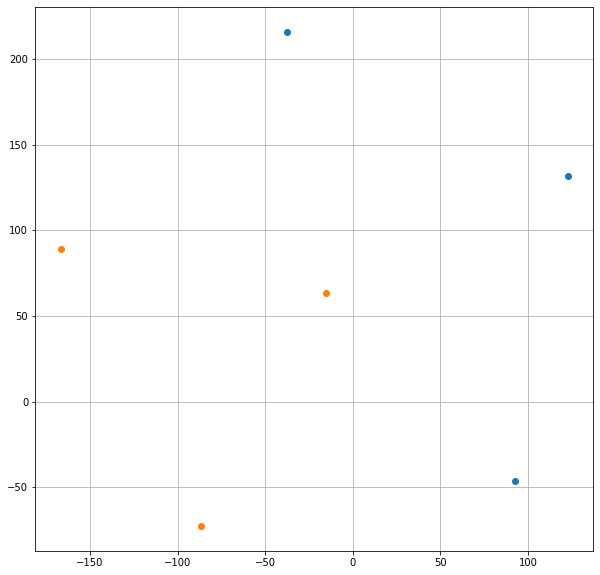

In [93]:
draw_embeddings(embs_2D, labels_for_viz, set(labels_for_viz))